###Лабораторная работа № 5. Сети с обратными связями
Выполнил: Степанов Данила Михайлович

Группа: М8О-407Б-20

Вариант: 22

###Цель работы
Целью работы является исследование свойств сетей Хопфилда, Хэмминга и Элмана, алгорит-
мов обучения, а также применение сетей в задачах распознавания статических и динамических
образов.

###Решение

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

Зададим сигналы для распознавания

In [2]:
p1 = lambda k: np.sin(4 * np.pi * k) # first signal, output = -1
p2 = lambda k: np.cos(-3 * k ** 2 + 5 * k + 10) # second signal, output = 1
step = 0.025
a0, b0 = 0, 1
a1, b1 = 0.24, 2.7
R = (2, 4, 4)

Сгенерируем данные для обучения

In [3]:
def generate_samples(p1, p2, step, seg1, seg2, R, input_size=6, tensors=False):
  a0, a1 = seg1
  a1, b1 = seg2
  p1_k, p2_k = np.arange(a0, a1, step), np.arange(a1, b1, step)
  p1_values, p2_values = p1(p1_k), p2(p2_k)
  X = np.concatenate((
      np.tile(p1_values, R[0]),
      p2_values,
      np.tile(p1_values, R[1]),
      p2_values,
      np.tile(p1_values, R[2]),
      p2_values
  ))

  k = np.arange(len(X)) * step

  p1_len, p2_len = p1_values.shape[0], p2_values.shape[0]

  y = np.concatenate((
      -np.ones(p1_len * R[0]),
      np.ones(p2_len),
      -np.ones(p1_len * R[1]),
      np.ones(p2_len),
      -np.ones(p1_len * R[2]),
      np.ones(p2_len)
  ))
  if tensors:
    X, y = X[0:len(X) - 1], y[0:len(y) - 1]
    size = len(X)
    return k[0:len(k) - 1], torch.reshape(torch.tensor(X, dtype=torch.float), (size // input_size, input_size)), torch.reshape(torch.tensor(y, dtype=torch.float), (size // input_size, input_size))
  else:
    return k, X, y

In [4]:
k, X, y = generate_samples(p1, p2, step, (a0, b0), (a1, b1), R)

In [5]:
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (397,)
y shape:  (397,)


Отобразим сигналы на графике

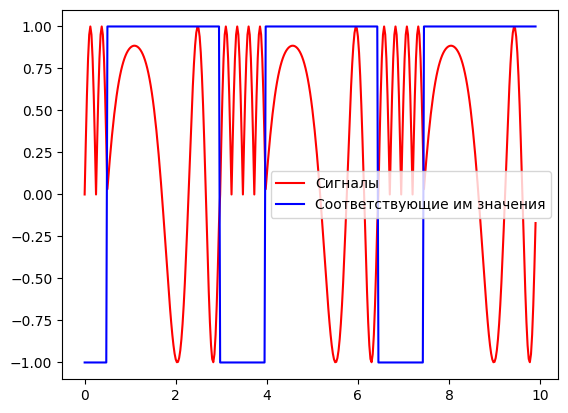

In [6]:
plt.plot(k, X, c='red')
plt.plot(k, y, c='blue')
plt.legend(["Сигналы", "Соответствующие им значения"])

In [7]:
np.random.uniform(size=(3,3))

array([[0.95916275, 0.47449873, 0.31417444],
       [0.50057648, 0.51385016, 0.28785039],
       [0.33781735, 0.32196073, 0.66977382]])

In [8]:
k, X, y = generate_samples(p1, p2, step, (a0, b0), (a1, b1), R, tensors=True)

In [9]:
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  torch.Size([66, 6])
y shape:  torch.Size([66, 6])


### Часть 1. Сеть Элмана

Опишем архитектуру сети Элмана и функцию прямого распространения

In [10]:
class ElmanModel(nn.Module):
  def __init__(self, input_size, hidden_size, bias=True):
    super().__init__()
    self.hidden_size = hidden_size
    self.Whx = nn.Parameter(torch.tensor(np.random.uniform(size=(input_size, hidden_size)), dtype=torch.float))
    self.Whh = nn.Parameter(torch.tensor(np.random.uniform(size=(hidden_size, hidden_size)), dtype=torch.float))
    self.g = nn.Tanh()
    self.lin = nn.Linear(hidden_size, input_size)
    if bias:
      self.b = nn.Parameter(torch.tensor(np.random.uniform(size=(1, hidden_size)), dtype=torch.float))

  def forward(self, X):
    outputs = torch.ones([66, 8])
    state = torch.tensor(np.random.uniform(size=(1, self.hidden_size)), dtype=torch.float)
    for index, x in enumerate(X):
      x = torch.reshape(x, (1, x.shape[0]))
      state = self.g(x @ self.Whx + state @ self.Whh + self.b)
      outputs[index, :] = state
    model_outputs = self.g(self.lin(outputs))
    return model_outputs

Опишем функцию для обучения модели

In [11]:
def train(model, criterion, X, y, optimizer, epochs=10):
  model.train()
  history = []
  for epoch in range(epochs):
    acc = 0.0
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    preds = outputs.clone().detach().cpu().numpy()
    myfunc_vec = np.vectorize(lambda x: 1 if x >= 0 else -1)
    true_values = y.clone().detach().cpu().numpy()
    preds = myfunc_vec(preds)
    true_values = myfunc_vec(true_values)
    acc = ((preds == true_values) & (preds == 1)).sum() / (preds.shape[0] * preds.shape[1])
    history.append(loss.item())
    if epoch % 1000 == 0:
      print("epoch=", epoch, " loss: ", loss.item(), " acc: ", round(acc, 3))
    loss.backward()
    optimizer.step()
  return history

Определим модель, функцию потерь и оптимизатор для обучения модели

In [12]:
epochs = 7000

model = ElmanModel(6, 8)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


history = train(model, criterion, X, y, optimizer, epochs=epochs)

epoch= 0  loss:  1.2656898498535156  acc:  0.424
epoch= 1000  loss:  0.5721129179000854  acc:  0.747
epoch= 2000  loss:  0.04560336843132973  acc:  0.745
epoch= 3000  loss:  0.01769094355404377  acc:  0.747
epoch= 4000  loss:  0.009537058882415295  acc:  0.747
epoch= 5000  loss:  0.006676618009805679  acc:  0.747
epoch= 6000  loss:  0.024208661168813705  acc:  0.747


Построим кривую обучения

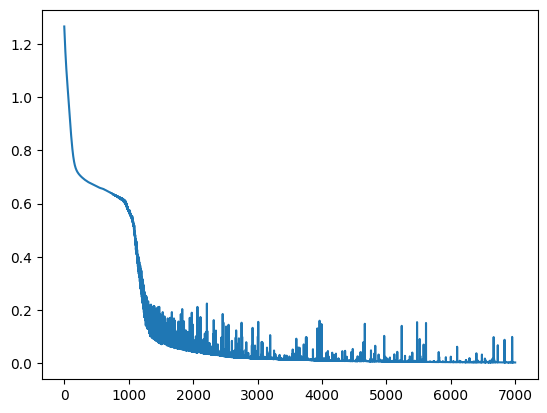

In [13]:
plt.plot(range(epochs), history)

Функция для отрисовки результата

In [14]:
def draw_result(model):
  k, X, y = generate_samples(p1, p2, step, (a0, b0), (a1, b1), R)
  k_tensor, X_tensor, y_tensor = generate_samples(p1, p2, step, (a0, b0), (a1, b1), R, tensors=True)
  outputs = model(X_tensor)
  preds = outputs.clone().detach().cpu().numpy()
  myfunc_vec = np.vectorize(lambda x: 1 if x >= 0 else -1)
  preds = myfunc_vec(preds)
  preds = preds.flatten()
  print("preds shape: ", preds.shape)
  plt.figure(figsize=(20, 10))
  plt.plot(k, X, c='red')
  #plt.plot(k, y, c='blue')
  plt.plot(k_tensor, preds, c='green')
  plt.legend(["Значения сигналов", "Предсказанные значения"])

Результат предсказания модели

preds shape:  (396,)


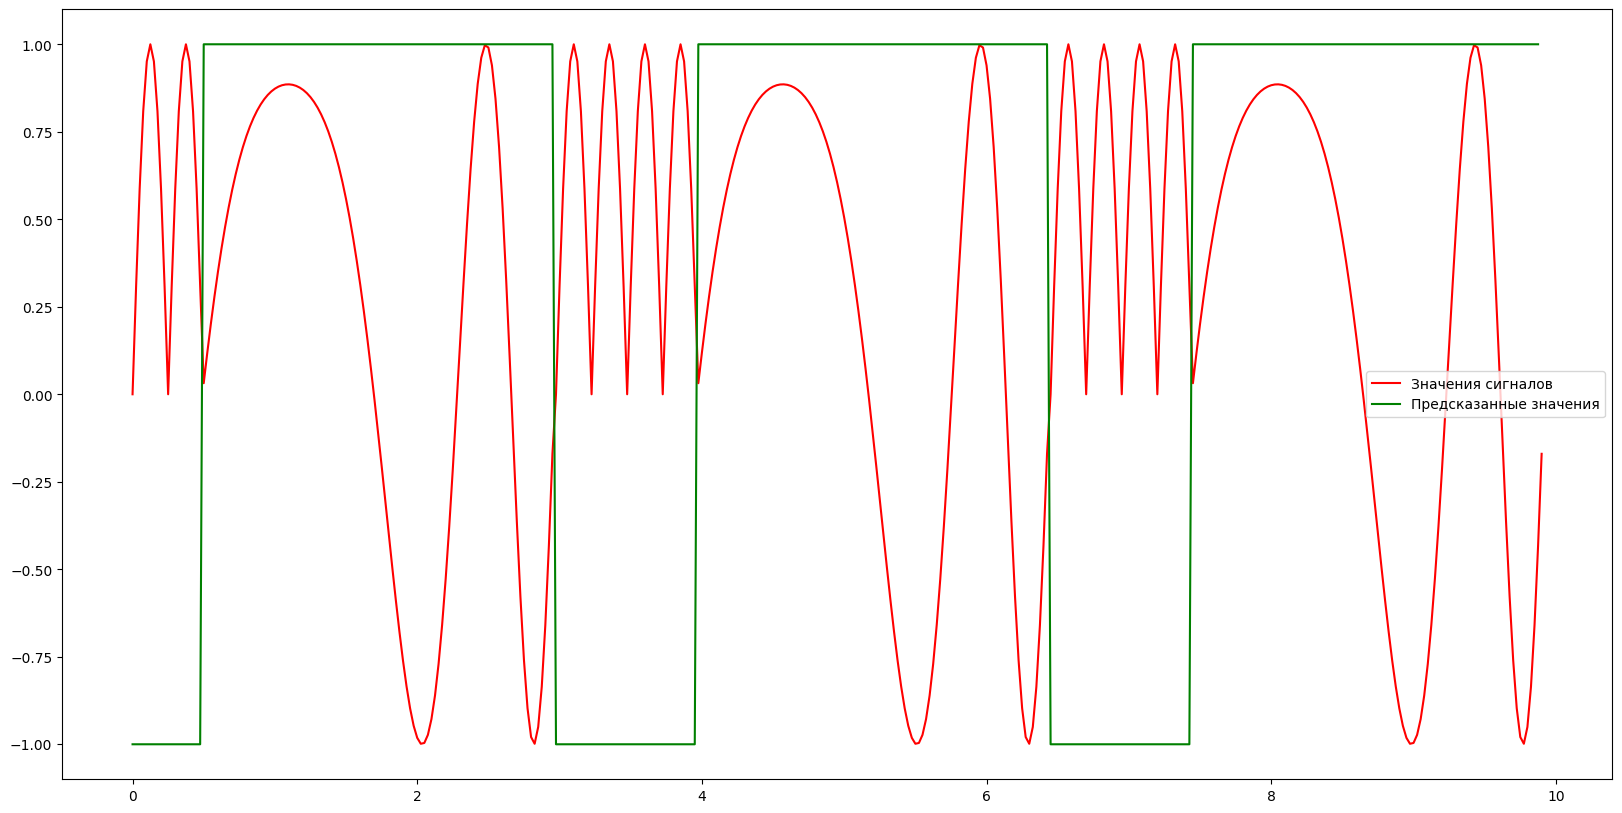

In [15]:
draw_result(model)

###Вывод:
сети с обратными связями отлично подходят для задач, где данные заданны в виде последовательности. Это могут быть NLP задачи, прогнозирование временных рядов или классификация сигналов, где некоторая структура может повторяться с течением времени. Основным недостатком сети Элмана является то, что по мере чтения токенов последовательности модель забывает, что было в начале.